# Introduction to Autoencoders and Variational Autoencoders

In this tutorial we will use Autoencoders (AE) and Variational Autoencoders (VAE) on sea surface temperature (SST) anomalies in the tropical Pacific.

The following packages are needed for this tutorial:

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy as ctp
import aeutils as ut
plt.style.use("./../paper.mplstyle")

## 1. Familiarize yourself with the data

Many atmospheric phenomena are driven by the oceans, since they contain most of the heat. Sea surface temperatures (SST) fields can help us predict and understand many atmospheric processes. Anomalies in the Pacific SST can lead to large climatic changes world wide. 

The monthly SST data from 1950-1979 and 1979-2021 are taken from [Copernicus ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview). The data are regridded on a $5^\circ \times 5^\circ$ resolution, detrended and then subtracted from their monthly climatology. The data can be found in "04_vae/data".

We use xarray to read the .nc files:

In [2]:
da = xr.open_dataset("./data/ssta_1950_2021.nc")['ssta']

We can easily plot the SST anomaly maps for some time points using the internal plotting function of xarray:

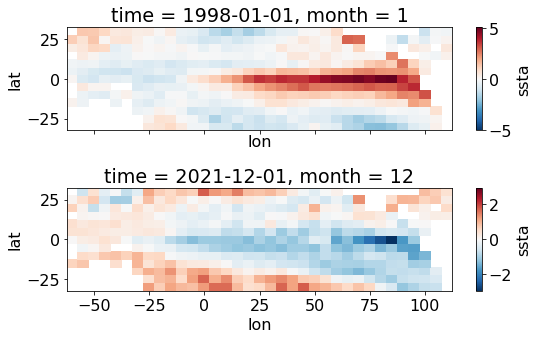

In [3]:
fig, axs = plt.subplots(2, sharex=True)
for i, t in enumerate(['1998-01', '2021-12']):
    da.sel(time=t).plot(ax=axs[i])

Nicer plots can be obtained by using cartopy. This however also requires many more lines of codes which you can find in the aeutils.py.

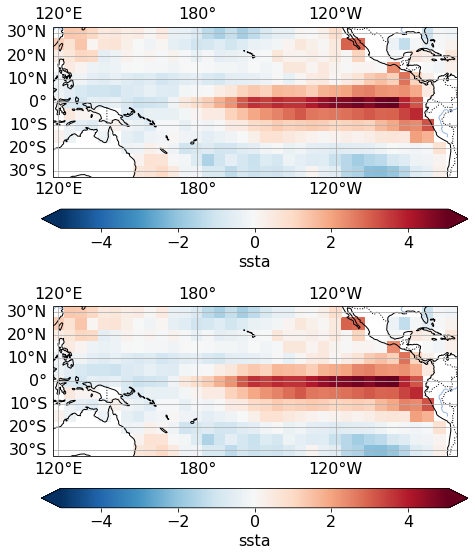

In [4]:
fig = plt.figure(figsize=(8,8))
for i, t in enumerate(['1998-01-01', '2021-12-01']):
    ax = fig.add_subplot(2,1,i+1, projection=ctp.crs.PlateCarree(central_longitude=180))
    ut.plot_map(da.sel(time='1998-01-01'), ax=ax, central_longitude=180)

### El Nino Southern Oscillation (ENSO)

The largest interanual variability of the climate is characterized by SST anomalies in the tropical Pacific, called the **El Nino Southern Oscillation (ENSOP)**. ENSO has a normal, warm phase called **El Nino** and a cold phase called **La Nina** with different impacts on global climate.

The phase of ENSO is defined using the average time series over the Nino3.4 region. The warm phase is defined as Nino3.4 > 0.5 and the cold phase as Nino3.4<-0.5. 

![Nino](img/nino_regions.png) [Ref.](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni)


With xarray selecting boxes and taking averages is an easy thing to do:

In [5]:
nino34_region = da.sel(lat=slice(-5,5), lon=[10, 60])
nino34 = nino34_region.mean(dim=('lon', 'lat'), skipna=True)

Text(0, 0.5, 'Nino3.4 index')

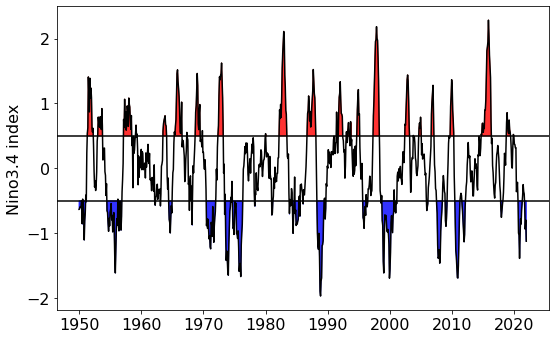

In [6]:
# Plot Nino3.4 index
fig, ax = plt.subplots()
ax.plot(nino34['time'].data, nino34.data, '-k')
ax.fill_between(nino34['time'].data, nino34.data, y2=0.5, where=nino34.data >= 0.5, color='r', alpha=0.8)
ax.fill_between(nino34['time'].data, nino34.data, y2=-0.5, where=nino34.data <= -0.5, color='b', alpha=0.8)
ax.axhline(-0.5, color='k')
ax.axhline(0.5, color='k')
ax.set_ylabel('Nino3.4 index')

## 2. Preprocess data for our deep learning framework

There are a whole zoo of deep learning libraries for python out there.

![Nino](img/dl_libraries.png) [Ref.](https://towardsdatascience.com/best-python-libraries-for-machine-learning-and-deep-learning-b0bd40c7e8c)

Here, we use pytorch since it is one of the most common used currently wich easily allows running your code on GPUs.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

Pytorch use their own datatype, pytorch.Tensors which is very similar to numpy. In order to use our SST anomaly data as inputs to neural networks (NN) we have to preprocess the data. The following preprocessing steps are usually required: 

1. **Adapt input size**: Since we will use linear NN, we have to flatten the maps into vectors.

2. **Normalization**: Data should be normalized, e.g. between 0 and 1. For anomaly data this is not necessarily required since the data is already bounded and equally distributed around 0.

It is convinient to define a Dataset class with which we can use the Dataloader objects predefined by pytorch. 

In [8]:

class SSTA(Dataset):
    """Dataset of SSTA used for pytorch.

    Args:
        dataarray (xr.DataArray): Dataarray containing SSTA. 
    """
    def __init__(self, dataarray):
        self.dataarray = dataarray
        self.time = self.dataarray['time'].data
        self.lat = self.dataarray['lat'].data
        self.lon = self.dataarray['lon'].data
        
        # Flatten map to vector
        X = self.dataarray.data.reshape(self.dataarray.shape[0], -1)
        # Remove Nans in vector
        self.idx_nan = np.isnan(X[0,:])
        self.X = X[:, ~self.idx_nan]
        

    def __len__(self):
        """Returns the number of datapoints."""
        return self.X.shape[0]
    

    def __getitem__(self, idx):
        """Required function to get items of dataset.

        Args:
            idx (int): Index to get datapoint.

        Returns:
            x (torch.Tensor): Datapoint
            l (dict): Label of datapoint. In this case just the index.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        x = torch.from_numpy(self.X[idx]).float()
        label = {'idx': idx}

        return x, label
    
    def get_map(self, x, name=None):
        """Reshape flattened vector with removed NaNs to xarray map.

        Args:
            data (torch.tensor): (x_dim) Flatten datapoint with NaNs removed

        Return:
            map (np.ndarray): 2d-map
        """
        if torch.is_tensor(x):
            x = x.to('cpu').detach().numpy()

        # Create array with NaNs
        x_map = np.ones((len(self.lat) * len(self.lon))) * np.NaN
        # fill array with sample
        x_map[~self.idx_nan] = x

        da_map = xr.DataArray(
            data=np.reshape(x_map, (len(self.lat), len(self.lon))),
            dims=['lat', 'lon'],
            coords=dict(lat=self.lat, lon=self.lon)
        )
        return da_map 
        

Lets have a look at our pytoch Dataset class.

In [9]:
dataset = SSTA(da)
# Sample datapoint
x, l = dataset[0]
x_dim = x.shape[0]
print(f"Shape of datapoint: {x_dim}")

Shape of datapoint: 394


When training a NN on data we always have to evaluate their performance on data which has not been used while training.

Therefore, we split the data randomly in a training and validation dataset, here 80% to 20%. 

In [10]:
n_training = int(len(dataset) * 0.8)
(train_data, val_data) = torch.utils.data.random_split(dataset, [n_training, len(dataset) - n_training])

To process a datapoints in parallel pytorch offers a ```Dataloader```. The Dataloader allows to process a set of datapoints, i.e. minibatch at the same time. The size of the minibatch depends on the number of datapoints we have. 

In [11]:
# Define data loader
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

## 3. Autoencoder

Now we can start defining our autoencoder (AE). AE are used to reconstruct high-dimensional data using NN with a narrow bottleneck layer. It is often used for dimensionality reduction, like Principal Component Analysis. AE are optimized to obtain good reconstructions.

The Autoencoder consists of:

- The encoder network $g_\phi(x)$ translates the input $x$ to the low-dimensional latent code $z$.
- The decoder network $f_\theta(z)$ recovers the data from the latent code.

<img src="img/autoencoder_sketch.png" width="900"> [Ref.](https://lilianweng.github.io/posts/2018-08-12-vae/)


We find the parameters $\theta$ and $\phi$ to minimize the reconstruction error:

$L_{\mathrm{AE}}(\theta, \phi)=\frac{1}{n} \sum_{i=1}^{n}\left(\mathbf{x}^{(i)}-f_{\theta}\left(g_{\phi}\left(\mathbf{x}^{(i)}\right)\right)\right)^{2}$



In this case we build a very simple Autoencoder with: 

- Encoder: $x$ -> Linear(512) -> Linear(2) -> $z$
- Decoder: $z$ -> Linear(512) -> Linear(394) -> $x'$
          

In [12]:
class AE(nn.Module):
    """Auto encoder.

    Args:
        z_dim (int): Dimension of latent space. 
        encoder ([type]): Encoder NN.
        decoder ([type]): Decoder NN.
    """

    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.device = torch.device(
                'cuda' if torch.cuda.is_available() else 'cpu')
        
        self. encoder = nn.Sequential(
            nn.Linear(x_dim, 512),
            nn.ReLU(),
            nn.Linear(512, z_dim),
        ).to(self.device)

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(),
            nn.Linear(512, x_dim),
        ).to(self.device)

    
    def forward(self, x):
        """Pass through encoder and decoder.
        
        Args:
            x (tensor): (batch, x_dim) Input to AE.
        
        Return:
            x_hat (tensor): (batch, x_dim ) Reconstruction of x.
            z (tensor): (batch, z_dim) Vector in latent space.
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return x_hat, z
    
    def loss(self, x):
        """Loss function of AE.

        Args:
            x (torch.Tensor): (batch, x_dim) Input to AE.

        Returns:
            rec_loss (torch.Tensor): Reconstruction loss between input and rec.
        """
        
        # Encode and decoder input 
        x_hat, z = self.forward(x)
        # Mean square error between reconstructed and input
        rec_loss_pointwise = F.mse_loss(x_hat, x, reduction='none')
        # Sum of point wise MSE
        rec_loss = torch.sum(torch.flatten(rec_loss_pointwise, start_dim=1), dim=-1)
        
        return rec_loss.mean()
        

Initialize the AE:

In [13]:
ae = AE(x_dim, z_dim=2)

print("Number of trainable parameters of our model:",
      sum(p.numel() for p in ae.parameters() if p.requires_grad))

Number of trainable parameters of our model: 406924


### Training an NN

We train the NN by computing the loss for each minibatch and update the gradients using backpropagation. We iterate $N$ epochs over the whole training data. No gradients are computed for the validation data.

In [14]:
def train_epoch(model, dataloader, optimizer):
    """Train model for one epoch.

    Args:
        model (nn.Module): Model to train
        dataloader (torch.Dataloader): Dataloader of trainingsdata.
        optimizer (torch.optim): Optimizer of model parameters.

    Returns:
        mean_epoch_loss (float): training loss of one epoch
    """
    # set model into training mode
    model.train()

    epoch_loss = 0.0
    for i, data in enumerate(dataloader):
        # Set gradients to zero in the beginning of each batch
        optimizer.zero_grad()

        # encoding and decoding
        data, _ = data
        data = data.to(model.device)

        # loss function
        loss = model.loss(data)

        # backward prop and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    mean_epoch_loss = epoch_loss / len(dataloader)

    return mean_epoch_loss


def validate_epoch(model, dataloader):
    """Validate model for one epoch.

    Args:
        model (nn.Module): VAE model to train.
        dataloader (torch.Dataloader): Dataloader of validation data.

    Returns:
        mean_epoch_loss (float): Validation loss of one epoch.
    """
    # Set model into validation mode
    model.eval()

    epoch_loss = 0.0
    # For validation no gradients are computed
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            data, _ = data
            data = data.to(model.device)

            # loss function
            loss = model.loss(data)
            epoch_loss += loss.item()

    mean_epoch_loss = epoch_loss / len(dataloader)

    return mean_epoch_loss

In [15]:
# The training loop
epochs = 50
learning_rate = 0.001
optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate)    

train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    val_epoch_loss = validate_epoch(
        ae, val_loader
    )
    train_epoch_loss = train_epoch(
        ae, train_loader, optimizer
    )

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

Epoch 1 of 50
Train Loss: 95.6483
Val Loss: 151.3590
Epoch 2 of 50
Train Loss: 83.6540
Val Loss: 86.5550
Epoch 3 of 50
Train Loss: 80.8745
Val Loss: 81.3192
Epoch 4 of 50
Train Loss: 79.0406
Val Loss: 82.1094
Epoch 5 of 50
Train Loss: 77.7695
Val Loss: 81.0409
Epoch 6 of 50
Train Loss: 77.7865
Val Loss: 79.0651
Epoch 7 of 50
Train Loss: 76.9120
Val Loss: 80.8768
Epoch 8 of 50
Train Loss: 77.8846
Val Loss: 79.7249
Epoch 9 of 50
Train Loss: 75.9509
Val Loss: 80.6929
Epoch 10 of 50
Train Loss: 76.0695
Val Loss: 79.9769
Epoch 11 of 50
Train Loss: 76.2214
Val Loss: 80.2012
Epoch 12 of 50
Train Loss: 75.0713
Val Loss: 79.2352
Epoch 13 of 50
Train Loss: 76.0050
Val Loss: 80.0299
Epoch 14 of 50
Train Loss: 74.7128
Val Loss: 79.7773
Epoch 15 of 50
Train Loss: 74.0512
Val Loss: 79.1891
Epoch 16 of 50
Train Loss: 73.6630
Val Loss: 79.2482
Epoch 17 of 50
Train Loss: 73.5521
Val Loss: 78.2161
Epoch 18 of 50
Train Loss: 73.9243
Val Loss: 78.7986
Epoch 19 of 50
Train Loss: 75.6277
Val Loss: 79.1006
E

The first evaluation of the training is by plotting the loss on the training data and on the validation data for each epoch:

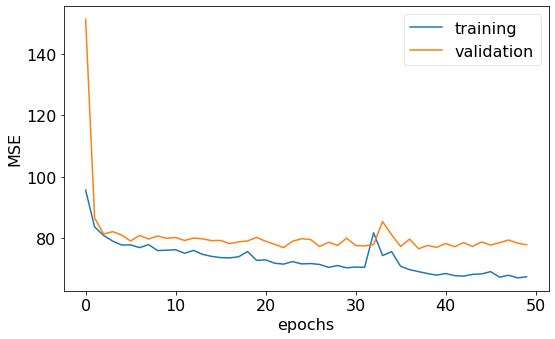

In [16]:
fig, ax = plt.subplots()
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_yscale('linear')
ax.set_xlabel('epochs')
ax.set_ylabel('MSE')
ax.legend()

We compare the input and reconstructed images qualitatively:

Text(0.5, 1.0, 'Reconstruced SSTA')

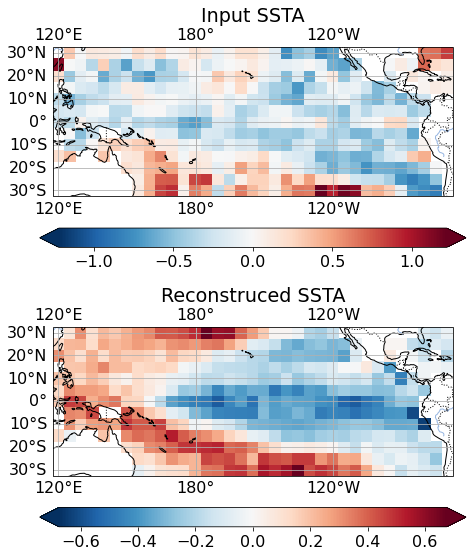

In [17]:
# select random inputs from validataion dataset
x, l = val_data[np.random.randint(0, len(val_data))]

# encode and decode input
x_rec, z = ae.forward(x.to(ae.device))

# transform flattened map back to grid
da_in = val_data.dataset.get_map(x)
da_rec = val_data.dataset.get_map(x_rec)

# Plotting
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8), subplot_kw=dict(
    projection= ctp.crs.PlateCarree(central_longitude=180))
)
ut.plot_map(da_in, ax=ax1, central_longitude=180)
ax1.set_title(f"Input SSTA")
ut.plot_map(da_rec, ax=ax2, central_longitude=180)
ax2.set_title("Reconstruced SSTA")


### The latent space

The bottleneck layer or latent space is a compressed low dimensional representation of the input. In the following we will analyze the structure of the latent space. Thereby, we will encode all input datapoints to the latent space.

Text(0, 0.5, '$z_2$')

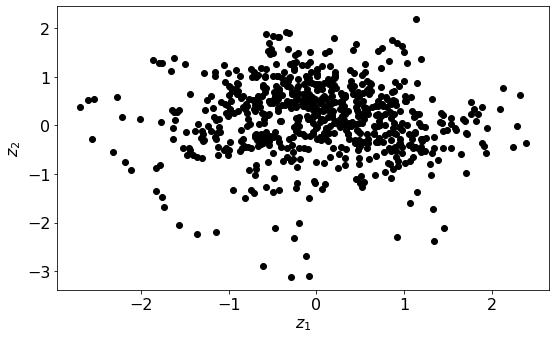

In [18]:
def encoding(model, dataloader):
    """Encoding dataset and store encoding.

    Args:
        model (nn.Module): AE model.
        dataloader (torch.Dataloader): Dataloader 

    Returns:
        encode (dict): Dictionary with encodings.
    """
    with torch.no_grad():
        encode = dict()
        for i, x in enumerate(dataloader):
            x, l = x
            out = model.forward(x.to(model.device))
            z = out[1]
            if i == 0:
                encode['z'] = z.cpu().detach().numpy()
                encode['idx'] = l['idx']
            else:
                encode['z'] = np.vstack([encode['z'], z.cpu().detach().numpy()])
                encode['idx'] = np.concatenate((encode['idx'], l['idx']))
    return encode

encode = encoding(ae, train_loader)

# Plot the encoding
fig, ax = plt.subplots()
ax.plot(encode['z'][:,0], encode['z'][:,1], 'ko')
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")

We can also for instance check how El Ninos and La Ninas are distributed in this space:

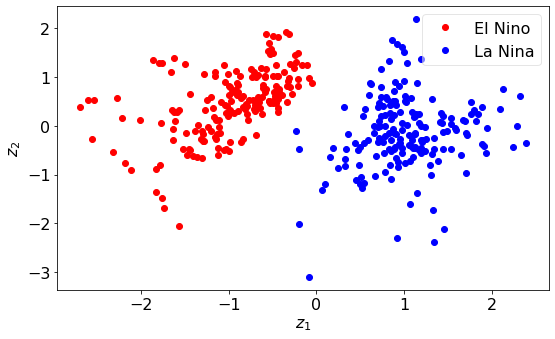

In [19]:
nino34_train = train_data.dataset.dataarray.sel(lat=slice(-5,5), lon=[10, 60]).mean(dim=('lon', 'lat'), skipna=True)

# get all encodings for El Nino conditions
nino_idx = np.flatnonzero(np.isin(encode['idx'], np.where(nino34_train.data > 0.5)[0]))
# get all encodings for La Nina conditions
nina_idx = np.flatnonzero(np.isin(encode['idx'], np.where(nino34_train.data < -0.5)[0]))


fig, ax = plt.subplots()
ax.plot(encode['z'][nino_idx, 0], encode['z'][nino_idx, 1], 'ro', label='El Nino')
ax.plot(encode['z'][nina_idx,0], encode['z'][nina_idx,1], 'bo', label='La Nina')
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.legend()


### Traversing the latent space

Another method for studying the latent space is by travsing (walking) through the low dimensional space and decoding each step.

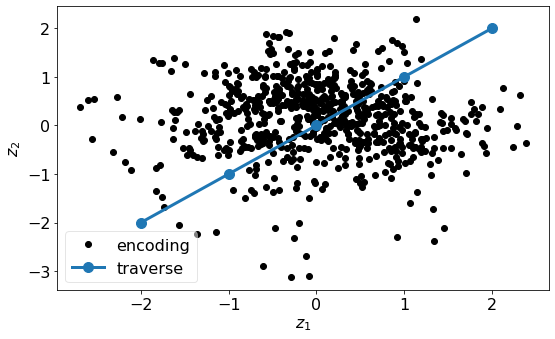

In [20]:
z_start = torch.Tensor([[0,0]])
z_eps = torch.Tensor([1,1])
z_range = torch.linspace(-2, 2, 5)

# Create traverse through latent space
z_samples = z_start.repeat(len(z_range), 1 ) + z_range.unsqueeze(1) * z_eps


# Plot latent space
fig, ax = plt.subplots()
ax.plot(encode['z'][:,0], encode['z'][:,1], 'ko', label='encoding')
ax.plot(z_samples[:,0], z_samples[:,1], '-o', label='traverse', 
        markersize=10, linewidth=3)
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.legend()

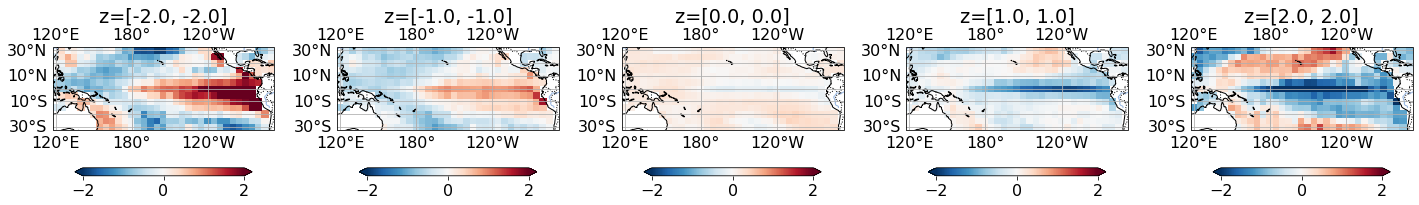

In [21]:
# Decode z
with torch.no_grad():
    traverse = ae.decoder(z_samples.to(ae.device))
    
# Plot reconstructions
fig, axs = plt.subplots(
    1, len(z_range), figsize=(len(z_range)*4, 4), 
    subplot_kw=dict(projection= ctp.crs.PlateCarree(central_longitude=180))
)
for i, rec in enumerate(traverse):
    da_rec = train_data.dataset.get_map(rec)
    ut.plot_map(da_rec, ax=axs[i], central_longitude=180, vmin=-2, vmax=2)
    axs[i].set_title(f"z={z_samples[i].tolist()}")

## 3. Variational Autoencoder

Variational Autoencoder is conceptually similar to an classical Autoencoder. VAEs are however mathematically quite different since we infer probability distributions over input $x$ and latent variables $z$. Instead of mapping the input $x$ to a fixed vectore, we map it into a conditional distribution which is parametrized by the encoder network. 

Our aim is to obtain the probability:

$p(z|x) = \frac{p_\phi(x|z) p(z)}{\int_z dz p_\phi(x|z) p(z)}$

where:
- $p(z)$ is the prior
- $p_\phi(x|z)$ is the likelihood parametrized by the decoder network
- $p_\theta(z|x)$ is the posterior distribution parametrized by the encoder network


We can formulate this problem as an optimization using variational inference. Our objective is the evidence lower bound (ELBO) which needs to be maximized, i.e.

$\theta^*, \phi^* = \argmin_{\theta, \phi} L_{\text{VAE}}(\theta, \phi) = \argmin_{\theta, \phi} \left[ -\mathbb{E}_{\mathbf{z} \sim q_{\phi}(\mathbf{z} \mid \mathbf{x})} \log p_{\theta}(\mathbf{x} \mid \mathbf{z})+D_{\mathrm{KL}}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}) \| p_{\theta}(\mathbf{z})\right) \right]$.

The first term is called the *reconstruction loss* and the second term is often denoted as a *regularization*.

### Kullback-Leibler divergence

In the ELBO above, we use the Kullback-Leibler (KL) divergence to write our inference problem. The KL-divergence quantifies the distance between tow distributions $Q$ and $P$ and is defined as,

$ D_{\mathrm{KL}}(Q \mid P)=\mathbb{E}_{z \sim Q(z)} \log \frac{Q(z)}{P(z)} $

Note that the KL-divergence is not symmetric, i.e. $D_{\mathrm{KL}}(Q \mid P) \neq D_{\mathrm{KL}}(P \mid Q)$.

In the case above the KL-divergence basically measures the distance between the prior $p(z)$ and the approximate likelihood $q_{\phi}(\mathbf{z} \mid \mathbf{x})$.

For two gaussians $q(z) = \mathcal{N}_1(\mu_1, \sigma_1^2 1)$ and $p(z) = \mathcal{N}_2(\mu_2, \sigma_2^2 1)$ the KL-divergence can be computed analytically as,

$D_{KL}(q|p) = 0.5 * \left[ log(\sigma_2) - log(\sigma_1) + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{\sigma_2^2 } -1 \right]$




In [22]:
def kl_normal(q_m, q_logv, p_m, p_logv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension.
 
    kl(q|p) = 0.5 * (log(p_v) - log(q_v) + (q_v**2 + (q_m - p_m)**2)/ p_v**2 - 1)

    Args:
        q_m (tensor): (batch, dim): q mean
        q_logv (tensor): (batch, dim): q log variance
        p_m (tensor): (batch, dim): p mean
        p_logv (tensor): (batch, dim): p log variance

    Return:
        kl (tensor):(batch,): kl between each sample
    """
    element_wise = 0.5 * (2*p_logv - 2*q_logv + q_logv.exp() / p_logv.exp()
                          + (q_m - p_m).pow(2) / p_logv.exp() - 1)
    kl = element_wise.sum(-1)
    return kl  

### Reparametrization Trick

The expectation term in the loss functions requires generating samples from $z \sim p_\phi(z|x)$. We however cannot backpropagate gradients through stochastic processes. In order to make the VAE still trainable we us the so called reparametrization trick. The reparametrization trick is basically a transformation of $z$ to an auxiliary independent random variable $\epsilon$ parametrized by $\phi$.

For multivariate Gaussians with diagonal covariance structure this transformation is easy, 

$\mathbf{z} \sim q_{\phi}\left(\mathbf{z} \mid \mathbf{x}^{(i)}\right)=\mathcal{N}\left(\mathbf{z} ; \boldsymbol{\mu}^{(i)}, \boldsymbol{\sigma}^{2(i)} \boldsymbol{I}\right)$

$\mathbf{z}=\boldsymbol{\mu}+\boldsymbol{\sigma} \odot \boldsymbol{\epsilon}, \text { where } \boldsymbol{\epsilon} \sim \mathcal{N}(0, \boldsymbol{I})\ $

In [23]:
def reparametrize(mu, log_v):
    """Sampling from a gaussian using the reparametrization trick.

    z = mu + v**2 * eps | eps ~ N(0,1)

    Args:
        mu (torch.Tensor): (batch, ...) mean from the encoder's latent space
        log_v (torch.Tensor): (batch, ...) log variance from the encoder's latent space
    
    Return:
        sample (tensor): (batch, ...)
    """
    std = torch.exp(0.5*log_v)  # standard deviation
    eps = torch.randn_like(std)
    sample = mu + (eps * std)  # sampling as if coming from the input space

    return sample

### Our VAE class

Lets define our VAE class similar to the AE class before. 

For simplisity we use the following simplifications which are often assumed for VAE:
1. We assume a standard normal prior $p(z) = \mathcal{N}(z; 0,1)$ 
2. The likelihood is gaussian $p_\phi(x|z) = \mathcal{N}(x; \mu_\phi(z), 1)$ parametrized by the decoder network. 
Thereby, $\log(p_\phi(x|z)) \propto MSE(x - x')$.
3. The posterior is also assumed to be Gaussian $q_\theta(z|x) = \mathcal{N}(z; \mu_\theta(x), \sigma_\theta^2(x) 1)$


<img src="img/vae_sketch.png" width="900"> [Ref.](https://lilianweng.github.io/posts/2018-08-12-vae/)


In [24]:
class VAE(nn.Module):
    """Variational Auto encoder.

    Args:
        z_dim (int): Dimension of latent space. 
        encoder ([type]): Encoder NN.
        decoder ([type]): Decoder NN.
    """

    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.device = torch.device(
                'cuda' if torch.cuda.is_available() else 'cpu')
        
        self. encoder = nn.Sequential(
            nn.Linear(x_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 2 * z_dim),
        ).to(self.device)

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(),
            nn.Linear(512, x_dim),
        ).to(self.device)

    
    def forward(self, x):
        """Pass through encoder and decoder.
        
        Args:
            x (tensor): (batch, x_dim) Input to AE.
        
        Return:
            x_hat (tensor): (batch, x_dim ) Reconstruction of x.
            q_m (tensor): (batch, z_dim) Mean of posterior q(z|x).
            q_logv (tensor): (batch, z_dim) Log variance of posterior q(z|x).
        """
        enc = self.encoder(x).view(-1, 2, self.z_dim) 
        q_m = enc[:, 0, :]
        q_logv = enc[:, 1, :]
        z_given_x = reparametrize(q_m, q_logv)
        x_hat = self.decoder(z_given_x)

        return x_hat, q_m, q_logv
    
    
    def loss(self, x):
        """Loss function of VAE is the negative log likelihood.

        Args:
            x (torch.Tensor): (batch, x_dim) Input to AE.

        Returns:
            rec_loss (torch.Tensor): Reconstruction loss between input and rec.
        """
        
        # Encode and decoder input 
        x_hat, q_m, q_logv = self.forward(x)
        
        # Reconstruction loss, log(p(x|z))
        rec_loss_pointwise = F.mse_loss(x_hat, x, reduction='none')
        rec_loss = torch.sum(
            torch.flatten(rec_loss_pointwise, start_dim=1), dim=-1)
        
        # KL divergence kl(q(z|x)|| p(z))
        p_m = torch.zeros_like(q_m)
        p_logv = torch.log(torch.ones_like(q_logv))
        kl = kl_normal(q_m, q_logv, p_m, p_logv)
        
        loss = rec_loss + kl
        
        return loss.mean()

Initialize out VAE model:

In [25]:
vae = VAE(x_dim, z_dim=2)

print("Number of trainable parameters of our model:",
      sum(p.numel() for p in vae.parameters() if p.requires_grad))

Number of trainable parameters of our model: 407950


### Training
Train VAE with the same training functions as the AE before.

In [26]:
# Training parameters
epochs = 50
learning_rate = 0.001
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)    

train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    val_epoch_loss = validate_epoch(
        vae, val_loader
    )
    train_epoch_loss = train_epoch(
        vae, train_loader, optimizer
    )

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

Epoch 1 of 50
Train Loss: 109.6495
Val Loss: 175.4237
Epoch 2 of 50
Train Loss: 94.9550
Val Loss: 98.6762
Epoch 3 of 50
Train Loss: 91.1371
Val Loss: 95.3836
Epoch 4 of 50
Train Loss: 91.3934
Val Loss: 92.5011
Epoch 5 of 50
Train Loss: 88.6499
Val Loss: 91.0999
Epoch 6 of 50
Train Loss: 87.6387
Val Loss: 90.3474
Epoch 7 of 50
Train Loss: 87.8388
Val Loss: 89.8766
Epoch 8 of 50
Train Loss: 87.2194
Val Loss: 91.9655
Epoch 9 of 50
Train Loss: 86.0300
Val Loss: 92.7093
Epoch 10 of 50
Train Loss: 86.0197
Val Loss: 89.1631
Epoch 11 of 50
Train Loss: 85.2370
Val Loss: 89.6843
Epoch 12 of 50
Train Loss: 84.2058
Val Loss: 89.3885
Epoch 13 of 50
Train Loss: 84.3309
Val Loss: 89.2710
Epoch 14 of 50
Train Loss: 83.8524
Val Loss: 88.5845
Epoch 15 of 50
Train Loss: 84.7637
Val Loss: 90.5160
Epoch 16 of 50
Train Loss: 83.2889
Val Loss: 88.6570
Epoch 17 of 50
Train Loss: 82.3543
Val Loss: 87.5395
Epoch 18 of 50
Train Loss: 81.9977
Val Loss: 88.4174
Epoch 19 of 50
Train Loss: 82.6751
Val Loss: 88.1806


Plotting the taining and validation loss over epochs.

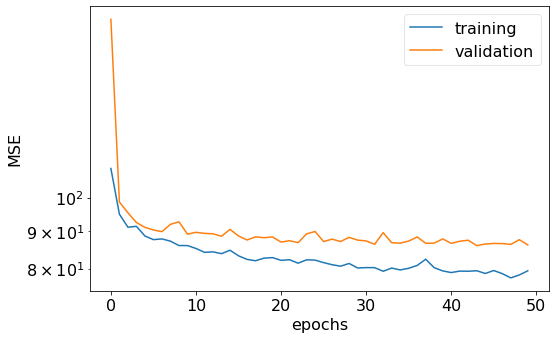

In [27]:
fig, ax = plt.subplots()
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_yscale('log')
ax.set_xlabel('epochs')
ax.set_ylabel('MSE')
ax.legend()

The reconstruction works the same, where we look at one decoded sample:

Text(0.5, 1.0, 'Reconstruced SSTA')

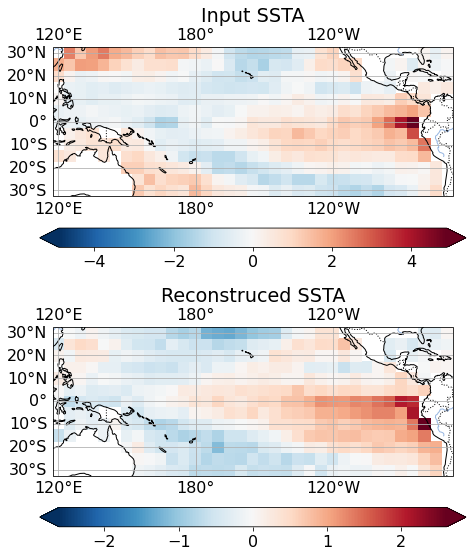

In [28]:
# select random inputs from validataion dataset
x, l = val_data[np.random.randint(0, len(val_data))]

# encode and decode input
x_rec, q_m, q_logv = vae.forward(x.to(vae.device))

# transform flattened map back to grid
da_in = val_data.dataset.get_map(x)
da_rec = val_data.dataset.get_map(x_rec[0])

# Plotting
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8), subplot_kw=dict(
    projection= ctp.crs.PlateCarree(central_longitude=180))
)
ut.plot_map(da_in, ax=ax1, central_longitude=180)
ax1.set_title(f"Input SSTA")
ut.plot_map(da_rec, ax=ax2, central_longitude=180)
ax2.set_title("Reconstruced SSTA")

### Latent space 

Very similar to the AE we can plot the latent space of the VAE. Keep in mind, that we are only plotting the mean of the posterior distribution $p(z|x)$. 

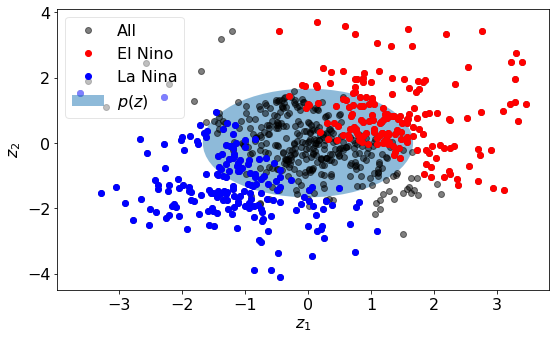

In [33]:
encode = encoding(vae, train_loader)

# get all encodings for El Nino and La Nina conditions
nino34_train = train_data.dataset.dataarray.sel(lat=slice(-5,5), lon=[10, 60]).mean(dim=('lon', 'lat'), skipna=True)
nino_idx = np.flatnonzero(np.isin(encode['idx'], np.where(nino34_train.data > 0.5)[0]))
nina_idx = np.flatnonzero(np.isin(encode['idx'], np.where(nino34_train.data < -0.5)[0]))


fig, ax = plt.subplots()
# Prior
ut.plot_2dgaussian(np.zeros(2), np.diag(np.ones(2)), p=0.5, ax=ax, alpha=0.5, label=f'$p(z)$')
# Mean of p(z|x)
ax.plot(encode['z'][:, 0], encode['z'][:, 1], 'ko', label='All', alpha=0.5)
ax.plot(encode['z'][nino_idx, 0], encode['z'][nino_idx, 1], 'ro', label='El Nino')
ax.plot(encode['z'][nina_idx,0], encode['z'][nina_idx,1], 'bo', label='La Nina')
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.legend()


### Latent space traverse

The Gaussian assumption on the prior enforces that points which are similar in $x$ need to be close in $z$. That allows smooth transitions from one point to the other in latent space.

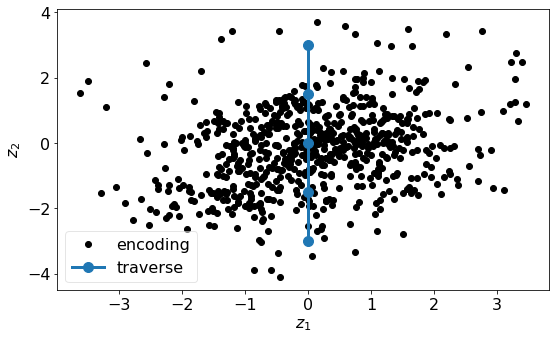

In [36]:
z_start = torch.Tensor([[0,0]])
z_eps = torch.Tensor([0,1])
z_range = torch.linspace(-3, 3, 5)

# Create traverse through latent space
z_samples = z_start.repeat(len(z_range), 1 ) + z_range.unsqueeze(1) * z_eps


# Plot latent space
fig, ax = plt.subplots()
ax.plot(encode['z'][:,0], encode['z'][:,1], 'ko', label='encoding')
ax.plot(z_samples[:,0], z_samples[:,1], '-o', label='traverse', 
        markersize=10, linewidth=3)
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.legend()

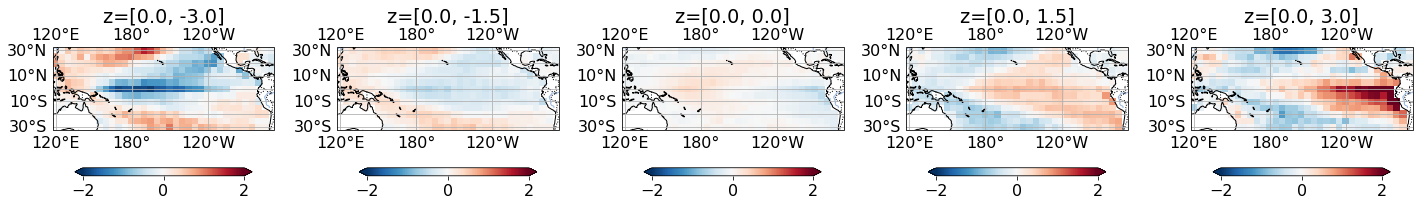

In [37]:
# Decode z
with torch.no_grad():
    traverse = vae.decoder(z_samples.to(ae.device))
    
# Plot reconstructions
fig, axs = plt.subplots(
    1, len(z_range), figsize=(len(z_range)*4, 4), 
    subplot_kw=dict(projection= ctp.crs.PlateCarree(central_longitude=180))
)
for i, rec in enumerate(traverse):
    da_rec = train_data.dataset.get_map(rec)
    ut.plot_map(da_rec, ax=axs[i], central_longitude=180, vmin=-2, vmax=2)
    axs[i].set_title(f"z={z_samples[i].tolist()}")

## More resources

1. [Blog by Lilian Weng](https://lilianweng.github.io/posts/2018-08-12-vae/)

2. [Mathy Bit blog](https://mathybit.github.io/auto-var/)

3. [Diederik P. Kingma, and Max Welling. “Auto-encoding variational bayes." ICLR 2014.](https://arxiv.org/abs/1312.6114)